In [1]:
import numpy as np
import pandas as pd
import pickle
import os

from create_sequences import create_sequences
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import  AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, LayerNormalization, Input
from generate_multivariate_samples import generate_multivariate_samples

import numpy as np
import plotly.graph_objs as go

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools

In [2]:
def model_generation():
    # Learning rate scheduler function
    def lr_scheduler(epoch, lr):
        return lr
        # if epoch < 30:
        #     return lr
        # elif epoch < 60:
        #     return lr * np.exp(-0.05)
        # else:
        #     return lr * np.exp(-0.1)

    model = Sequential()

    model.add(Input((X_train.shape[1], X_train.shape[2])))

    # First LSTM layer with LayerNormalization and recurrent dropout
    model.add(LSTM(64,
                activation='tanh', recurrent_activation='sigmoid',
                return_sequences=True, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())
    # model.add(Dropout(0.1))

    # Second LSTM layer with residual connection, LayerNormalization, and recurrent dropout
    model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid',
                return_sequences=True, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())
    # model.add(Dropout(0.1))

    # Third LSTM layer (final) without returning sequences, adding residual connection
    model.add(LSTM(256, activation='tanh', recurrent_activation='sigmoid',
                return_sequences=False, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())

    # Dense layer with LeakyReLU activation for flexibility in output
    model.add(Dense(len(predictors_lst)))
    # model.add(LeakyReLU(alpha=0.1))  # LeakyReLU is more flexible for output regression

    # Compile the model using AdamW optimizer and a learning rate scheduler
    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)  # AdamW improves generalization
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [3]:
df_all = pd.read_csv('eua_price_data.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)

<Axes: xlabel='Date'>

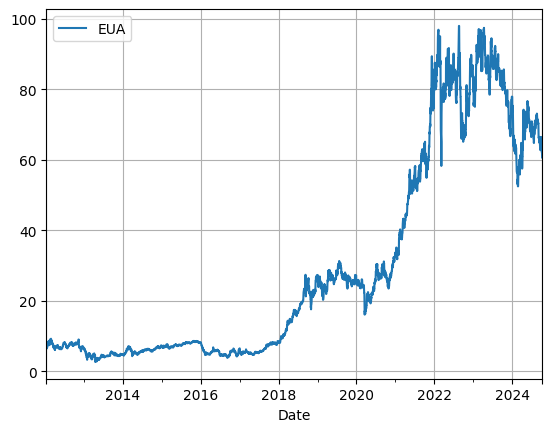

In [4]:
df_all.plot(kind='line', x = 'Date', y = 'EUA', grid ='on')

In [5]:
df_all = df_all[(df_all['Date'] > pd.to_datetime('2020-11-24')) & (df_all['Date'] < pd.to_datetime('2024-10-07'))].reset_index(drop=True)

In [16]:
for predictors_lst in [ ['Oil', 'Coal', 'NG', 'USEU', 'S&P_clean', 'DAX'],
                        ['Market_size', 'Oil', 'Coal', 'NG', 'USEU', 'S&P_clean', 'DAX'],
                        ['Market_size', 'Oil', 'Coal', 'NG', 'USEU', 'S&P_clean', 'DAX', 'GDP'], 
                        ['Market_size', 'Oil', 'Coal', 'NG', 'USEU', 'S&P_clean', 'DAX', 'Power'],
                        ['Market_size', 'Oil', 'Coal', 'NG', 'USEU', 'S&P_clean', 'DAX', 'IR']
                       ]:
    for sequence_length in tqdm([7, 14, 28, 56]):
        original_EUA = df_all['EUA'].values  
        data = df_all[predictors_lst].values  
        dates = df_all['Date'].values

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)

        test_data_size = sequence_length + 1

        test_data_scaled = data_scaled[-(test_data_size + 1):] 
        test_dates = dates[-(test_data_size + 1):]
        train_data_scaled = data_scaled[:-(2)]
        train_dates = dates[:-(2)]

        X_train, y_train = create_sequences(train_data_scaled, sequence_length)
        X_test, y_test = create_sequences(test_data_scaled, sequence_length)
        print(X_train.shape, X_test.shape)

        checkpoint_path = f"./saved_model_hj_all/model_length_{sequence_length:02}_{'+'.join(predictors_lst)}.keras"
        history_path = os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0])

        model = model_generation()

        try:
            model.load_weights(checkpoint_path) 
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
        except:
            def lr_scheduler(epoch, lr):
                return lr
            # Learning rate scheduler callback
            lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

            checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                        monitor='val_loss', 
                                        save_best_only=True,
                                        mode='min',  
                                        verbose=1)

            early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)

            history = model.fit(X_train, y_train, epochs=1000, batch_size=512,
                                validation_data = (X_test, y_test),
                                #validation_split=0.05,
                                verbose=0, callbacks=[checkpoint, lr_scheduler_callback, early_stopping])# ,early_stopping]) 
            
            with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'wb') as f:
                pickle.dump(history, f)
            
        model.load_weights(checkpoint_path) 
        
        plt.figure()
        plt.plot(history.history['loss'], alpha = 0.5 ,label='Training loss')
        plt.plot(history.history['val_loss'], alpha = 0.5 , label='Validation loss')
        plt.legend()
        plt.yscale('log')
        plt.savefig(f"./saved_model_hj_all/history_length_{sequence_length:02}_{'+'.join(predictors_lst)}.pdf")

        # accuracy plot
        train_predictions = model.predict(X_train, verbose = 0);
        train_predictions_rescaled = scaler.inverse_transform(train_predictions)
        test_predictions = model.predict(X_test, verbose = 0);
        test_predictions_rescaled = scaler.inverse_transform(test_predictions)

        ground_truth_train = scaler.inverse_transform(y_train)
        ground_truth_test = scaler.inverse_transform(y_test)

        plt.figure(figsize = (13,13))
        for i, feature in enumerate(predictors_lst):
            plt.subplot(len(predictors_lst)//3 + 1 if len(predictors_lst)%3 !=0 else len(predictors_lst)//3, 3, i+1)
            plt.scatter(ground_truth_train[:,i],train_predictions_rescaled[:,i], label = 'train')
            plt.scatter(ground_truth_test[:,i],test_predictions_rescaled[:,i], label = 'test')
            plt.plot([min(ground_truth_train[:,i]), max(ground_truth_train[:,i])], 
                    [min(ground_truth_train[:,i]), max(ground_truth_train[:,i])], color='red', label='1:1 Line')

            plt.title(feature)
            plt.legend()
            plt.grid('on')
            plt.xlabel('ground truth')
            plt.ylabel('prediction')
            plt.tight_layout()
        plt.savefig(f"./saved_model_hj_all/accuracy_length_{sequence_length:02}_{'+'.join(predictors_lst)}.pdf")

        # get RMSE:
        rel_erorrs = []
        for i in range(train_predictions_rescaled.shape[1]):
            prediction = train_predictions[:, i]
            ground_truth = y_train[:,i]
            rel_error = np.mean(np.sqrt(((prediction-ground_truth)**2)))
            print(predictors_lst[i])
            print(rel_error)
            rel_erorrs.append(rel_error)
        

        for factor in [1, 3, 5]:
            # future prediction:
            num_of_prediction = 30*24
            num_ensemble = 100
            rel_erorrs_mat = np.array([rel_erorrs for i in range(num_ensemble)])
            corr = df_all[predictors_lst].corr()

            next_predictions = []
            current_input = train_predictions[-sequence_length:, :]
            current_input = np.array([current_input for i in range(num_ensemble)]).squeeze()
            for iter_ in range(num_of_prediction):
                next_prediction = model.predict(current_input, verbose = 0)
                error_p = generate_multivariate_samples(corr, n_samples=num_ensemble)
                next_prediction = next_prediction * (1+error_p*rel_erorrs_mat*factor)
                next_predictions.append(next_prediction)
                current_input = np.concatenate([current_input[:,1:], 
                                                next_prediction.reshape(next_prediction.shape[0],1,
                                                                        next_prediction.shape[1])], axis=1)
            next_predictions = np.array(next_predictions)
            future_dates = [pd.to_datetime(train_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]
            ensemble_future_predictions = np.array([scaler.inverse_transform(next_predictions[i]) for i in range(num_of_prediction)])


            # Calculate mean, P10, and P90 of predictions
            mean_predictions = ensemble_future_predictions[:, :, 0].mean(axis=1)
            P50 = np.percentile(ensemble_future_predictions[:, :, 0], 50, axis=1)
            P10 = np.percentile(ensemble_future_predictions[:, :, 0], 10, axis=1)
            P90 = np.percentile(ensemble_future_predictions[:, :, 0], 90, axis=1)

            # Create the plot
            plt.figure(figsize=(10, 6))

            # Plot historical EUA prices
            plt.plot(dates, original_EUA, label='Historical EUA Price', color='blue')

            # Plot all realizations
            for realization in ensemble_future_predictions[:, :, 0].T:
                plt.plot(future_dates, realization, color='gray', alpha=0.3)

            # Plot P10 and P90 percentile predictions
            plt.plot(future_dates, P10, label='P10 & P90', color='green', linestyle='-')
            plt.plot(future_dates, P90, color='green', linestyle='-')
            # Plot mean of future predictions
            plt.plot(future_dates, P50, label='Median of Predictions', color='red')


            # Customize the plot
            plt.title('EUA Price Prediction for the Next 24 Months')
            plt.xlabel('Date')
            plt.ylabel('EUA Price')
            plt.legend(loc='upper left')
            plt.grid(True)

            # Show the plot
            plt.savefig(f"./saved_model_hj_all/timeplot_factor_{factor}_length_{sequence_length:02}_{'+'.join(predictors_lst)}.pdf")


  0%|          | 0/4 [00:00<?, ?it/s]

I0000 00:00:1728912747.472297 1840351 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.


(1403, 7, 6) (2, 7, 6)


I0000 00:00:1728912747.472558 1840351 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:d5:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728912747.508612 1840351 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728912747.508676 1840351 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:d5:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728912747.508707 1840351 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728912747.508738 1840351 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:d5:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 2.8680
Epoch 1: val_loss improved from inf to 0.46694, saving model to ./saved_model_hj_all/model_length_07_Oil+Coal+NG+USEU+S&P_clean+DAX.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 547ms/step - loss: 2.8177 - val_loss: 0.4669 - learning_rate: 0.0010
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1.0380
Epoch 2: val_loss did not improve from 0.46694
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 1.0316 - val_loss: 0.8851 - learning_rate: 0.0010
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.9161
Epoch 3: val_loss did not improve from 0.46694
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.9089 - val_loss: 0.4882 - learning_rate: 0.0010
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.6521
Epoch 4: val_loss improved from 0.46694 to 0.40961, saving model to ./saved_model_hj_all/model_length_07_Oil+Coal+NG+USEU+S&P_clean+DAX.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.6454 - val_loss: 0

1. Layer Normalization: Replacing BatchNormalization with LayerNormalization for RNNs/LSTMs. Layer normalization is often more effective for sequential data as it normalizes across the features rather than the batch, avoiding issues with batch-dependent statistics in recurrent networks.

1. Recurrent Dropout: Added recurrent_dropout to regularize the recurrent connections, which helps in preventing overfitting in LSTMs.

1. Use of Residual Connections: Added skip (residual) connections between LSTM layers. These are particularly useful for deep RNN architectures as they help mitigate vanishing gradient issues and allow the model to learn better representations.

1. Learning Rate Schedule: Implemented a learning rate scheduler to adjust the learning rate dynamically, which can improve convergence and reduce the risk of overshooting.

1. Optimization: Used the AdamW optimizer instead of Adam. AdamW decouples weight decay from the learning rate, often leading to better generalization.

1. Leaky ReLU for Dense Layer: Changed the activation of the final dense layer to LeakyReLU for a more flexible activation in the prediction layer.

In [26]:
num_of_prediction = 30*24
num_ensemble = 100
rel_erorrs_mat = np.array([rel_erorrs for i in range(num_ensemble)])
corr = df_all[predictors_lst].corr()
for factor in [0.25, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0]:
    next_predictions = []
    current_input = train_predictions[-sequence_length:, :]
    current_input = np.array([current_input for i in range(num_ensemble)]).squeeze()
    for iter_ in tqdm(range(num_of_prediction)):
        next_prediction = model.predict(current_input, verbose = 0)
        error_p = generate_multivariate_samples(corr, n_samples=num_ensemble)
        next_prediction = next_prediction * (1+error_p*rel_erorrs_mat*factor)
        next_predictions.append(next_prediction)
        current_input = np.concatenate([current_input[:,1:], 
                                        next_prediction.reshape(next_prediction.shape[0],1,
                                                                next_prediction.shape[1])], axis=1)
    next_predictions = np.array(next_predictions)
    future_dates = [pd.to_datetime(train_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]
    ensemble_future_predictions = np.array([scaler.inverse_transform(next_predictions[i]) for i in range(num_of_prediction)])


    # Calculate mean, P10, and P90 of predictions
    mean_predictions = ensemble_future_predictions[:, :, 0].mean(axis=1)
    P50 = np.percentile(ensemble_future_predictions[:, :, 0], 50, axis=1)
    P10 = np.percentile(ensemble_future_predictions[:, :, 0], 10, axis=1)
    P90 = np.percentile(ensemble_future_predictions[:, :, 0], 90, axis=1)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot historical EUA prices
    plt.plot(dates, original_EUA, label='Historical EUA Price', color='blue')

    # Plot all realizations
    for realization in ensemble_future_predictions[:, :, 0].T:
        plt.plot(future_dates, realization, color='gray', alpha=0.3)

    # Plot P10 and P90 percentile predictions
    plt.plot(future_dates, P10, label='P10 & P90', color='green', linestyle='-')
    plt.plot(future_dates, P90, color='green', linestyle='-')
    # Plot mean of future predictions
    plt.plot(future_dates, P50, label='Median of Predictions', color='red')


    # Customize the plot
    plt.title('EUA Price Prediction for the Next 24 Months')
    plt.xlabel('Date')
    plt.ylabel('EUA Price')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.savefig(f"Result_timeplot_factor_{str(factor).replace('.','_')}.pdf")
    np.save(f"Result_ensemble_{str(factor).replace('.','_')}.npy", ensemble_future_predictions)

 38%|███▊      | 277/720 [01:18<02:07,  3.49it/s]

In [ ]:
num_of_prediction = 30*24
num_ensemble = 100
rel_erorrs_mat = np.array([rel_erorrs for i in range(num_ensemble)])
corr = df_all[predictors_lst].corr()
for factor in [10.0,20.0,30.0]:
    next_predictions = []
    current_input = train_predictions[-sequence_length:, :]
    current_input = np.array([current_input for i in range(num_ensemble)]).squeeze()
    for iter_ in tqdm(range(num_of_prediction)):
        next_prediction = model.predict(current_input, verbose = 0)
        error_p = generate_multivariate_samples(corr, n_samples=num_ensemble)
        next_prediction = next_prediction * (1+error_p*rel_erorrs_mat*factor)
        next_predictions.append(next_prediction)
        current_input = np.concatenate([current_input[:,1:], 
                                        next_prediction.reshape(next_prediction.shape[0],1,
                                                                next_prediction.shape[1])], axis=1)
    next_predictions = np.array(next_predictions)
    future_dates = [pd.to_datetime(train_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]
    ensemble_future_predictions = np.array([scaler.inverse_transform(next_predictions[i]) for i in range(num_of_prediction)])


    # Calculate mean, P10, and P90 of predictions
    mean_predictions = ensemble_future_predictions[:, :, 0].mean(axis=1)
    P50 = np.percentile(ensemble_future_predictions[:, :, 0], 50, axis=1)
    P10 = np.percentile(ensemble_future_predictions[:, :, 0], 10, axis=1)
    P90 = np.percentile(ensemble_future_predictions[:, :, 0], 90, axis=1)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot historical EUA prices
    plt.plot(dates, original_EUA, label='Historical EUA Price', color='blue')

    # Plot all realizations
    for realization in ensemble_future_predictions[:, :, 0].T:
        plt.plot(future_dates, realization, color='gray', alpha=0.3)

    # Plot P10 and P90 percentile predictions
    plt.plot(future_dates, P10, label='P10 & P90', color='green', linestyle='-')
    plt.plot(future_dates, P90, color='green', linestyle='-')
    # Plot mean of future predictions
    plt.plot(future_dates, P50, label='Median of Predictions', color='red')


    # Customize the plot
    plt.title('EUA Price Prediction for the Next 24 Months')
    plt.xlabel('Date')
    plt.ylabel('EUA Price')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.savefig(f"Result_timeplot_factor_{str(factor).replace('.','_')}.pdf")
    np.save(f"Result_ensemble_{str(factor).replace('.','_')}.npy", ensemble_future_predictions)

In [21]:

# # Create traces for each plot
# trace1 = go.Scatter(x=dates, y=original_EUA, mode='lines', name='Historical EUA Price', 
#                     line=dict(color='blue'))

# trace2 = go.Scatter(x=future_dates, y=ensemble_future_predictions[:,:,0].mean(axis = 1), 
#                     mode='lines', 
#                     name='mean of predictions', 
#                     line=dict(color='red'))

# trace3 = go.Scatter(x=future_dates, y=np.percentile(ensemble_future_predictions[:,:,0], 10, axis =1),  
#                     mode='lines', 
#                     name='P10', 
#                     line=dict(color='red', dash ='dash'))

# trace4 = go.Scatter(x=future_dates, y=np.percentile(ensemble_future_predictions[:,:,0], 90, axis =1), 
#                     mode='lines', 
#                     name='P90',  
#                     line=dict(color='red', dash ='dash'))

# trace5 = go.Scatter(x=future_dates, 
#                     y=ensemble_future_predictions[:,:,0], 
#                     mode='lines', 
#                     name='realizations',  
#                     line=dict(color='gray'))

# # trace5 = go.Scatter(x=train_dates[-train_predictions_rescaled.shape[0]:], 
# #                     y=train_predictions_rescaled[:, 0], mode='lines+markers', 
# #                     name='Train Predicted EUA Price', marker=dict(color='green', size=4), 
# #                     line=dict(color='green'))

# # Layout for the plot
# layout = go.Layout(
#     title='EUA Price Prediction for the Next 24 Months',
#     xaxis=dict(title='Date'),
#     yaxis=dict(title='EUA Price'),
#     legend=dict(x=0, y=1, traceorder='normal'),
#     height=600,
#     width=1000
# )

# # Create the figure with the traces
# fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5], layout=layout)

# # Show the figure (interactive plot)
# fig.show()

In [22]:
# plt.figure(figsize=(10, 6))
# plt.plot(dates, original_EUA, 'b', label='Historical EUA Price')  # 원본 EUA 데이터
# # plt.plot(train_dates, scaler.inverse_transform(test_data_scaled)[:, 0], 'skyblue', label='Test EUA Price')  # 테스트 데이터
# plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'red', linewidth = 0.1, label = 'real_1')
# plt.plot(future_dates, ensemble_future_predictions[1, :, 0].T, 'purple', linewidth = 0.1, label = 'real_2')
# plt.plot(future_dates, ensemble_future_predictions[2, :, 0].T, 'yellow', linewidth = 0.1, label = 'real_3')
# plt.plot(train_dates[-train_predictions_rescaled.shape[0]:], train_predictions_rescaled[:, 0], 'g.', marker='.', markersize=2, label='Train Predicted EUA Price')


# plt.xlabel('Date')
# plt.ylabel('EUA Price')
# plt.title('EUA Price Prediction for the Next 24 Months')
# plt.legend()
# plt.show()

In [ ]:
## TODO: compare with the above noise make method

import numpy as np

# Define your parameters
mean_vector = np.array([mean1, mean2, mean3])  # Replace with actual means for each variable
correlation_matrix = np.array([[1, corr12, corr13],   # Replace with your correlation values
                                [corr21, 1, corr23],
                                [corr31, corr32, 1]])
rmse_vector = np.array([rmse1, rmse2, rmse3])  # Replace with actual RMSE values for each variable

# Step 1: Create the covariance matrix
D = np.diag(rmse_vector)  # Diagonal matrix with RMSE values
covariance_matrix = D @ correlation_matrix @ D  # Covariance matrix

# Step 2: Generate random noise from the multivariate normal distribution
noise = np.random.multivariate_normal(mean_vector, covariance_matrix)

# Step 3: Add noise to the original data
original_data = np.array([[data1_variable1, data1_variable2, data1_variable3],  # Replace with your actual data
                           [data2_variable1, data2_variable2, data2_variable3],
                           ...])  # Continue for all your data points

# Assuming you want to add noise to each row of original_data
noisy_data = original_data + noise
